In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import albumentations as A
import datetime
import io
from sklearn.metrics import confusion_matrix

In [2]:
from tensorflow.keras.layers import Conv2D,MaxPool2D, Dense,Flatten, InputLayer,BatchNormalization, Input
from tensorflow.keras.layers import Layer, Dropout,Resizing, Rescaling, RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2, L1
from tensorboard.plugins.hparams import api as hp
from tensorflow.train import BytesList, FloatList, Int64List, Example, Feature, Features
import cv2

### Data Managment

#### Data downloading

In [3]:
!pip install -q kaggle

In [4]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Colab_Notebooks/Practice/kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 308M/309M [00:16<00:00, 16.9MB/s]
100% 309M/309M [00:16<00:00, 19.6MB/s]


In [7]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/sample_data/datasets"

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/sample_data/datasets/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/sample_data/datasets/Emoti

#### Data Loading

In [101]:
train_directory = r"/content/sample_data/datasets/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/sample_data/datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES =  ["angry", "happy", "sad"]

In [102]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
}

In [103]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [104]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [105]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

### Data Visualization

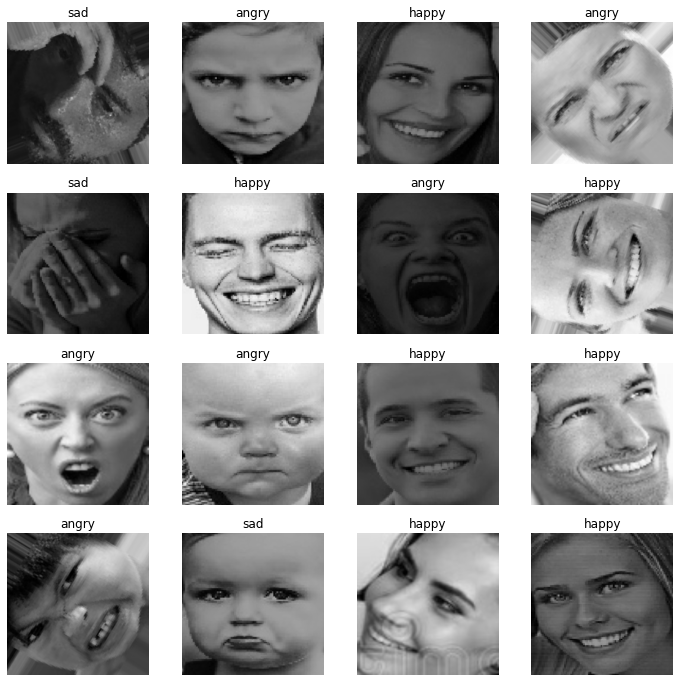

In [106]:
plt.figure(figsize = (12,12))
for images,labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
    plt.axis("off")


### Data Augumentation

In [107]:
augument_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025),),
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.1),
])

#0.025*360

In [108]:
def augument_layer(image,label):
  return augument_layers(image, training=True), label

#### Cutmix Augmentation

In [109]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_w//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_w//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w


In [110]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.crop_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.crop_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1-(r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype= tf.float32)
  label = lamda*tf.cast(label_1, dtype=tf.float32) + (1-lamda)*tf.cast(label_2, dtype=tf.float32)

  return image, label

In [111]:
train_dataset_1 = train_dataset.map(augument_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augument_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

### Dataset Preparation

In [112]:
train_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [117]:
validation_dataset = (
    val_dataset  
    #.prefetch(tf.data.AUTOTUNE)
)

#### resize and rescale

In [114]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

In [115]:
training_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [118]:
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

### TFRecords

In [ ]:
training_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
validation_dataset = (
    validation_dataset
    .unbatch()
)

In [ ]:
training_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'label': int_feature,
          
      }))
  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image, tf.argmax(label)

In [ ]:
encoded_dataset = (
    training_dataset
    .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )
  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:
      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
recon_dataset = tf.data.TFRecordDataset(filenames=[])

In [ ]:
l=[PATH.forma]

### Modeling

In [119]:
lenet_model=tf.keras.Sequential([
    #InputLayer(input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    InputLayer(input_shape = (None,None,3)),
    #Rescaling(1./255, name='rescaling'),
    resize_rescale_layers,

    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"],
           activation='relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']*2),
    Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2+4, kernel_size=CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"],
           activation='relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES']*2),
    Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    Flatten(),
    
    Dense(CONFIGURATION["N_DENSE_1"], activation='relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Dense(CONFIGURATION["N_DENSE_2"], activation='relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')
])

lenet_model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_12 (Bat  (None, 254, 254, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 127, 127, 6)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 16)    

### Training

In [120]:
loss_function = CategoricalCrossentropy(from_logits=False)

In [121]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]

In [122]:
lenet_model.compile(
    optimizer=Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss=loss_function,
    metrics=metrics
)

In [123]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 10, #CONFIGURATION['N_EPOCHS'], 
    verbose=1
)

Epoch 1/10


InvalidArgumentError: ignored

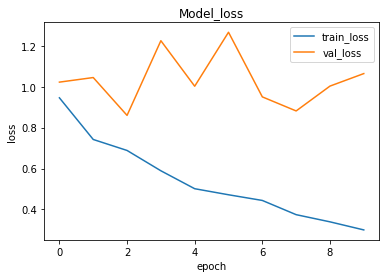

In [124]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

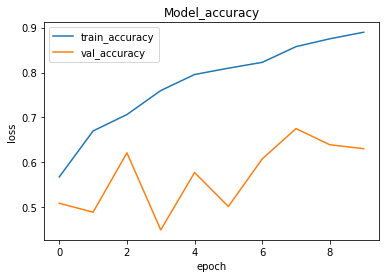

In [125]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model_accuracy")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

### Evaluation

In [126]:
lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 4s 47ms/step - loss: 1.1033 - accuracy: 0.3209 - top_k_accuracy: 0.6962


[1.1032602787017822, 0.3208955228328705, 0.6962247490882874]

### Testing

In [ ]:
test_image = cv2.imread("/content/sample_data/datasets/Emotions Dataset/Emotions Dataset/test/sad/10416.jpg_rotation_2.jpg")
im  =tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)

#print(lenet_model(im))
print(CLASS_NAMES[tf.argmax(lenet_model(im), axis=1).numpy()[0]])

happy


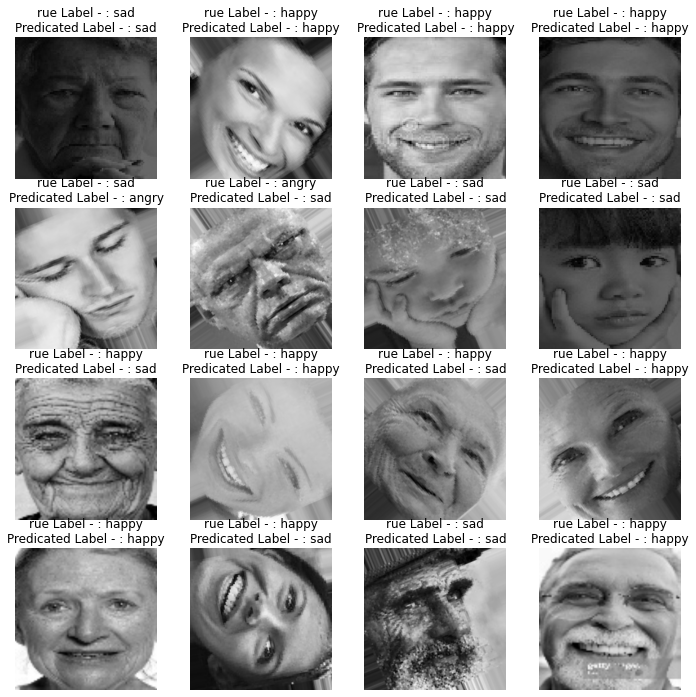

In [ ]:
plt.figure(figsize = (12,12))
for images,labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title("rue Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()] + "\n"+ "Predicated Label - : " + CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i], axis=0)).numpy()[0])])
    plt.axis("off")


### Confusion Matrix

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(),np.argmax(labels[-1], axis=-1).flatten()]))

print(np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()]))

[1 2 2 ... 0 1 1]
[1 2 2 ... 0 2 1]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(),np.argmax(labels[-1], axis=-1).flatten()])

[[311  64 140]
 [ 52 786 168]
 [ 48  91 618]]


Text(0.5, 51.0, 'Predicted')

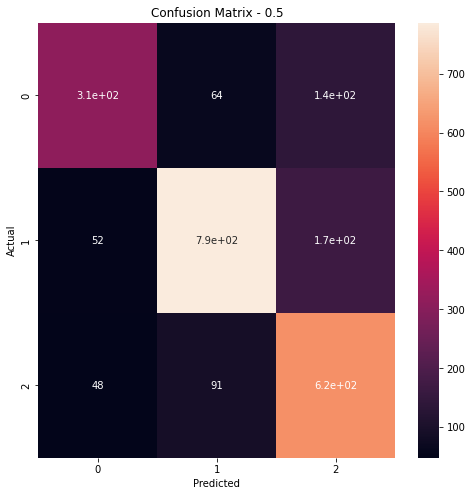

In [ ]:
threshold = 0.5

cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title("Confusion Matrix - {}".format(threshold))
plt.ylabel("Actual")
plt.xlabel("Predicted")
